### Modified PAA model by Scott Lee, systrader79

1. 전략의 컨셉
 
 - 다중 모멘텀 기반의 multi asset dynamic asset allocation model
 
 - 1~12개월 상대 모멘텀 n개 선정 --> 현금 혼합 --> 자산군 비중 배분 --> 최종 수익곡선 모멘텀 (6개월) 적용
 
 
2. 기존 모멘텀 전략 대비 장점
 
 - 추세 추종 전략의 노이즈를 먼저 제거한 상태에서 상대 모멘텀 전략 적용 ---> 훨씬 안정적
 
 - 모든 자산과 구조적으로 상관성이 낮을 수 밖에 없는 현금을 2회 연속 혼합한 수익 곡선을 하나의 자산군으로 이용 ---> 개별 자산 간의 상관성이 높아지는 구간에서도 낮은 포트폴리오 상관성 유지 가능 ----> 구조적인 drawdown 감소 효과
 
 - 복잡한 계산이 불필요 (상관성, 변동성 불필요) 하면서도 낮은 MDD와 높은 CAGR 달성 가능
 
 - 최적화를 배제 ---> input 데이터와 무관하게 구조적으로 robust 
   (실제로 어떤 자산군, 어떤 정도의 상대 모멘텀을 적용하더라도 수익곡선에는 큰 변화가 없음)
   
 - 수익곡선 모멘텀을 처음 적용하는 시점에서 현금 비율 조절함으로써, aggressive, moderate, conservative 모델로 기호에 따라 자유롭게 조절 가능
 
  - 현금 조절 로직과 더불어 투자하기 원하는 자산군 및 해당 투자 비중을 투자자 구미에 맞게 조절 가능 ---> DIY 포트폴리오 운용 가능
  
  - ETF를 이용한 로보어드바이저나, 개인화된 투자 솔루션에 최적
 

In [77]:
#1. 데이터 가져오기

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import matplotlib
matplotlib.rc('font', family='Malgun Gothic',size=8, weight = 'bold')

파일 = pd.ExcelFile('D:\지키자\시스템 트레이딩\systrader 전략\변형 MPAA 전략 코드\포트폴리오 데이터 가공 (통합).xlsx')
자산군 = 파일.sheet_names
자산군

['국가', '섹터', '팩터', '채권', '현금']

In [78]:
#2. 자산군별 데이터 프레임 설정

자료 = {}
for i in 자산군:
    자료[i] = 파일.parse(i)
    자료[i].index = 자료[i].날짜
    자료[i].drop('날짜', axis = 1, inplace=True)
    print(i+'개수',len(자료[i].columns))

국가개수 19
섹터개수 10
팩터개수 4
채권개수 2
현금개수 1


In [79]:
#3. 함수 설정

def 월간수익률(데이터):
    return 데이터 / 데이터.shift(1)

def 변동성대비모멘텀(데이터):
    a = 데이터/데이터.shift(12)
    b = 월간수익률(데이터).rolling(12).std()
    return a/b

def 연평균수익률(데이터):
    return 데이터/데이터.shift(12)

def 평균모멘텀(데이터):
    초기값 = 0
    for i in range(1, 13):
        초기값 = 데이터 / 데이터.shift(i) + 초기값
    return 초기값 / 12

def 모멘텀순위(데이터, 순위):
    x = 평균모멘텀(데이터)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= 순위] = 1
    y[y > 순위] = 0
    return y

def 평균모멘텀스코어(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 13):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/12
    return a

def 평균모멘텀스코어6(데이터):
    a = 평균모멘텀(데이터).copy()
    초기값 = 0
    for i in range(1, 7):
        초기값 = np.where(데이터 / 데이터.shift(i) > 1, 1, 0) + 초기값
    a[a > -1] = 초기값/6
    return a

def 현금혼합모멘텀수익곡선(데이터, 현금비율=1):
    x = 월간수익률(자료['현금'])*현금비율
    a = pd.DataFrame((월간수익률(데이터).values*평균모멘텀스코어(데이터).shift(1).values+x.values)/(현금비율+평균모멘텀스코어(데이터).shift(1).values)).cumprod() 
    a.index = 데이터.index
    a.columns = 데이터.columns
    return a

def 자산군통합포트(데이터, 순위, 자산군비중):
    x = 월간수익률(현금혼합모멘텀수익곡선(데이터))
    y = np.where(모멘텀순위(데이터, 순위).shift(1)==0,np.nan,자산군비중/순위)
    z = ((x*y).sum(1)).dropna()
    z = z.replace(0, np.nan)
    return z

def 통합모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    a = 자산군통합포트(자료['국가'],6,국가비중)
    b = 자산군통합포트(자료['섹터'],4,섹터비중)
    c = 자산군통합포트(자료['팩터'],2,팩터비중)
    d = 자산군통합포트(자료['채권'],1,채권비중)
    e = (pd.concat([a, b, c, d], axis=1).sum(1)/(국가비중+섹터비중+팩터비중+채권비중))
    e = e.replace(0,np.nan).cumprod()
    e.columns = ['통합수익']
    return e

def 수익곡선모멘텀(국가비중,섹터비중,팩터비중,채권비중):
    x = 월간수익률(자료['현금'])
    y = pd.DataFrame(통합모멘텀(국가비중,섹터비중,팩터비중,채권비중), index = x.index)    
    a = pd.DataFrame((월간수익률(y).values*평균모멘텀스코어6(y).shift(1).values+(1-평균모멘텀스코어6(y).shift(1).values)*x.values), index = x.index).cumprod().dropna()
    return a


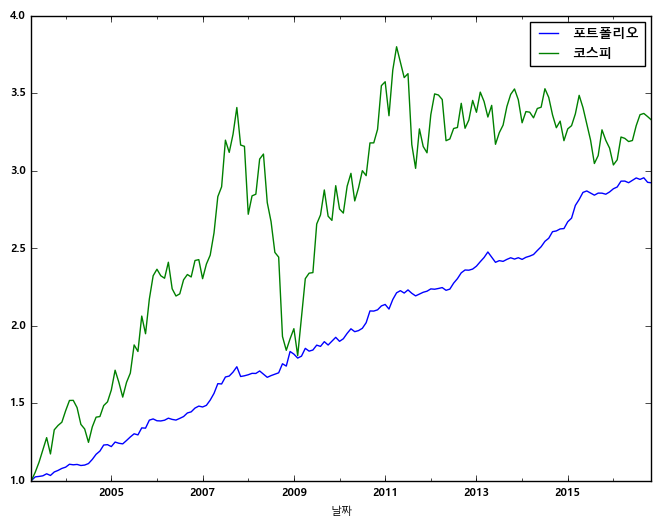

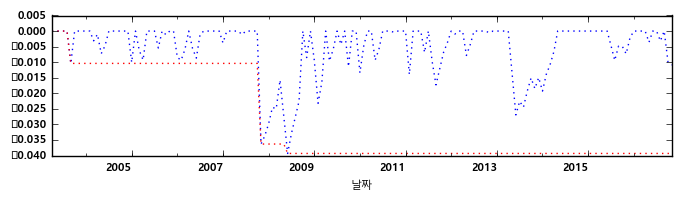

MDD : -3.93%
CAGR : 8.23%


In [80]:
#4. 결과 plot
# 국가, 섹터, 팩터, 채권

a = 수익곡선모멘텀(1,0,0,1)
b = 자료['국가'].한국/자료['국가'].한국.ix[0]
c = pd.concat([a, b], axis=1).dropna()
c.columns = ['포트폴리오', '코스피']
c.divide(c.ix[0]).plot(figsize = (8,6))
plt.show()

#5. MDD
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (8,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (8,2), color = 'red', linestyle='dotted')
plt.show()

#6. MDD / CAGR
투자기간 = len(c.index)/12
print("MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("CAGR : "+str(c.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")
